<a href="https://colab.research.google.com/github/naimurborno/Implementation-of-Vision-Transformer/blob/main/Object_Detection_using_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import layers
import shutil
import scipy.io
from tensorflow import keras

In [2]:
#define the multi layer perceptron network
def mlp(x,hidden_units,dropout_rate):
  for units in hidden_units:
    x=tf.keras.layers.Dense(units,activation=tf.nn.gelu)(x)
    x=tf.keras.layers.Dropout(dropout_rate)(x)
  return x

In [14]:
path_images = "/101_ObjectCategories/airplanes/"
path_annot = "/Annotations/Airplanes_Side_2/"

path_to_downloaded_file = tf.keras.utils.get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # downloaded file format
    cache_dir="/",  # cache and extract in current directory
)

# Extracting tar files found inside main zip file
shutil.unpack_archive("/datasets/caltech-101/101_ObjectCategories.tar.gz", "/")
shutil.unpack_archive("/datasets/caltech-101/Annotations.tar", "/")

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]

    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.utils.load_img(
        path_images + image_paths[i],
    )
    (w, h) = image.size[:2]

    # resize train set images
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )
# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

<ipython-input-14-90fd3003968b>:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


In [5]:
#define Patches layers
class Patches(layers.Layer):
  def __init__(self,patch_size):
    super().__init__()
    self.patch_size=patch_size

  def get_config(self):
    config=super().get_config().copy()
    config.update(
        {
            'input_shape':input_shape,
            'patch_size':patch_size,
            'num_patches':num_patches,
            'projection_dim':projection_dim,
            'num_heads':num_heads,
            'transformer_units':transformer_units,
            'transformer_layers':transformer_layers,
            'mlp_head_units':mlp_head_units
        }
    )
    return config
  def call(self,images):
    batch_size=tf.shape(images)[0]
    patches=tf.image.extract_patches(
        images=images,
        sizes=[1,self.patch_size,self.patch_size,1],
        strides=[1,self.patch_size,self.patch_size,1],
        rates=[1,1,1,1],
        padding='VALID'
    )
    return tf.reshape(patches,[batch_size,-1,patches.shape[-1]])

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


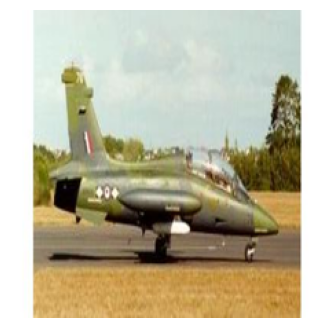

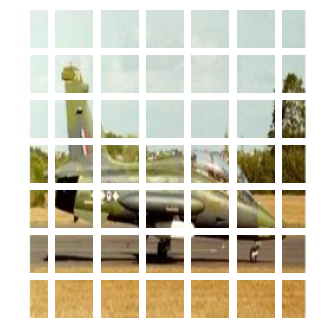

In [15]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [21]:
#define patch Encoder
class PatchEncoder(layers.Layer):
  def __init__(self,num_patches,projection_dim):
    super().__init__()
    self.num_patches=num_patches
    self.projection=tf.keras.layers.Dense(units=projection_dim)
    self.position_embedding=tf.keras.layers.Embedding(input_dim=num_patches,output_dim=projection_dim)

  def get_config(self):
    config=self().get_config().copy()
    config.update(
        {
            'input_shape':input_shape,
            'patch_size':patch_size,
            'num_patches':num_patches,
            'projection_dim':projection_dim,
            'num_heads':num_heads,
            'transformer_units':transformer_units,
            'transformer_layers':transformer_layers,
            'mlp_head_units':mlp_head_units
        }

    )
    return config

  def call(self,patch):
    position=tf.range(start=0,limit=self.num_patches,delta=1)
    encoded=self.projection(patch)+self.position_embedding(position)
    return encoded

In [26]:
def create_vit_object_detector(input_shape,patch_size,num_patches,projection_dim,num_heads,transformer_units,transformer_layers,mlp_head_units
                               ):
  input=tf.keras.layers.Input(shape=input_shape)
  patches=Patches(patch_size)(input)
  encoded_patch=PatchEncoder(num_patches,projection_dim)(patches)
  for _ in range(transformer_layers):
    x1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patch)
    attention_head=tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=projection_dim,dropout=0.1)(x1,x1)
    x2=tf.keras.layers.Add()([attention_head,encoded_patch])
    x3=tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
    x3=mlp(x3,hidden_units=transformer_units,dropout_rate=0.2)
    encoded_patch=tf.keras.layers.Add()([x3,x2])
  representation=tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patch)
  representation=tf.keras.layers.Flatten()(representation)
  representation=tf.keras.layers.Dropout(0.3)(representation)
  features=mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.3)
  bounding_box=tf.keras.layers.Dense(4)(features)
  return tf.keras.Model(inputs=input,outputs=bounding_box)

In [28]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tf.optimizers.Adam()

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 [==============================] - 13s 97ms/step - loss: 1.0623 - accuracy: 0.3108 - val_loss: 0.3588 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 1s 70ms/step - loss: 0.4274 - accuracy: 0.1892 - val_loss: 0.3091 - val_accuracy: 1.0000
Epoch 3/100
18/18 [==============================] - 2s 125ms/step - loss: 0.3249 - accuracy: 0.5451 - val_loss: 0.2675 - val_accuracy: 1.0000
Epoch 4/100
18/18 [==============================] - 2s 117ms/step - loss: 0.2514 - accuracy: 0.6111 - val_loss: 0.2273 - val_accuracy: 1.0000
Epoch 5/100
18/18 [==============================] - 1s 56ms/step - loss: 0.2127 - accuracy: 0.6094 - val_loss: 0.1906 - val_accuracy: 1.0000
Epoch 6/100
18/18 [==============================] - 1s 83ms/step - loss: 0.1837 - accuracy: 0.5885 - val_loss: 0.1577 - val_accuracy: 1.0000
Epoch 7/100
18/18 [==============================] - 3s 151ms/step - loss: 0.1474 - accuracy: 0.5521 - val_loss: 0.1276 - val_accuracy: 1.000